<a href="https://colab.research.google.com/github/Jiyong-Jeon/GAN_study/blob/main/GAN_In_Action/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자 입력으로 사용될 잡음 벡터의 크기
z_dim = 100

## 생성자 구현
- Conv는 전통적으로 '높이x너비x컬러 채널 수' 차원을 가진 이미지를 입력으로 받아 클래스 점수를 담은 1xn차원의 벡터 하나를 출력
- 이 과정을 거꾸로하여 벡터를 받아 크기를 늘린 후 이미지를 생성
- 핵심요소 **전치합성곱(Transposed convolution)**

- 잡음 벡터 z에서 '높이x너비x컬러 채널 수'를 가진 이미지를 출력

- 과정
  1. 랜덤 잡음 벹거를 받아 완전 연결층으로 7x7x256 크기의 텐서로 바꿈
  2. 전치합성곱을 사용해 7x7x256 크기의 텐서를 14x14x128 텐서로 변환
  3. 배치정규화와 LeakyReLU 활성화 함수 적용
  4. 전치합성곱을 사용해 14x14x128 크기의 텐서를 14x14x64 텐서로 변환. 이때 stride 변수를 1로 지정하여 너비와 높이 차원을 바꾸지 않음
  5. 배치정규화와 LeakyReLU 활성화 함수 적용
  6. 전치합성곱을 사용해 14x14x64 크기의 텐서를 28x28x1 로 변환.
  7. tanh 활성화 함수 적용

In [3]:
def build_generator(z_dim):
    model = Sequential()
    # 완전 연결층을 통해 입력을 7x7x256 크기 텐서로 변환
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # 7x7x256에서 14x14x128 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization()) # 배치 정규화
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLU 활성화 함수

    # 14x14x128에서 14x14x64 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization()) # 배치 정규화
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLU 활성화 함수

    # 14x14x64에서 28x28x1 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh')) # tanh 활성화 함수를 사용한 출력층

    return model

## 판별자 구현
- 과정
  1. 합성곱 층을 사용해 28x28x1 입력 이미지를 14x14x32 크기 텐서로 변환
  2. LeakyReLU 활성화 함수 적용
  3. 합성곱 층을 사용해 14x14x32 크기 텐서를 7x7x64 크기 텐서로 변환
  4. LeakyReLU 활성화 함수 적용
  5. 합성곱 층을 사용해 7x7x64 크기 텐서를 3x3x128 크기 텐서로 변환
  6. LeakyReLU 활성화 함수 적용
  7. 3x3x128 크기 텐서를 펼침

In [4]:
def build_discriminator(img_shape):

    model = Sequential()

    # 28x28x1에서 14x14x32 텐서로 바꾸는 합성곱 층
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLU 활성화 함수

    # 14x14x32에서 7x7x64 텐서로 바꾸는 합성곱 층
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLU 활성화 함수

    # 7x7x64에서 3x3x128 텐서로 바꾸는 합성곱 층
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLU 활성화 함수

    # sigmoid 활성화 함수를 사용한 출력층
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

## DCGAN 모델 생성

In [5]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model # 생성자 -> 판별자로 연결된 모델

In [6]:
# 판별자 모델 생성 및 컴파일
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# 생성자 모델 생성
generator = build_generator(z_dim)

# 생성자 훈련시 판별자의 파라미터를 고정
discriminator.trainable = False

# 생성자를 훈련하기 위해 판별자를 고정한 GAN 모델을 만들고 컴파일
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## DCGAN 훈련

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):
    # MNIST 데이터셋 로드
    (X_train, _), (_, _) = mnist.load_data()
    # [0, 255] 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    # 진짜 이미지 레이블: 모두 1
    real = np.ones((batch_size, 1))
    # 가짜 이미지 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    # 훈련 시작
    for iteration in range(iterations):
        # 판별자 훈련
        # 진짜 이미지에서 랜덤 배치 가져오기
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z, verbose=0)

        # 판별자 학습
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        #  생성자 훈련
        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z, verbose=0)

        # 생성자 학습
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:
            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            # 훈련 과정 출력
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            # 생성된 이미지 샘플 출력
            sample_images(generator)

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z, verbose=0)
    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5
    # 이미지 그리드 설정 (4x4)
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

11490434/11490434 [==============================] - 2s 0us/step
1000 [D 손실: 0.350707, 정확도: 86.33%] [G 손실: 2.099757]


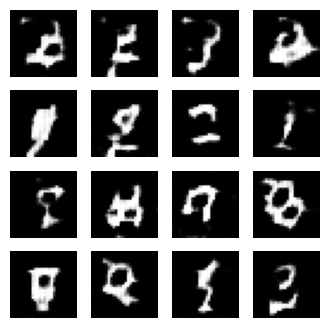

2000 [D 손실: 0.457643, 정확도: 78.52%] [G 손실: 1.568731]


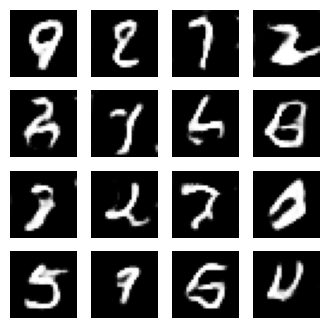

3000 [D 손실: 0.403991, 정확도: 78.91%] [G 손실: 1.684426]


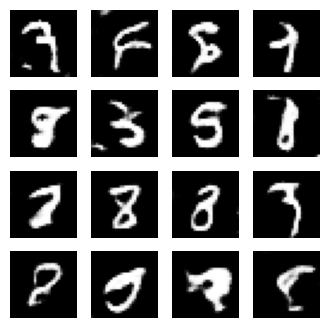

4000 [D 손실: 0.501529, 정확도: 74.61%] [G 손실: 1.579529]


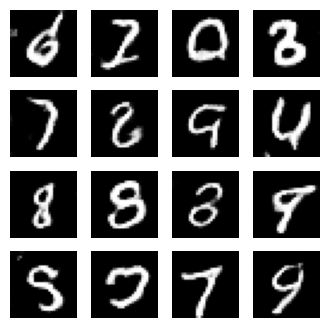

5000 [D 손실: 0.442357, 정확도: 75.78%] [G 손실: 1.853314]


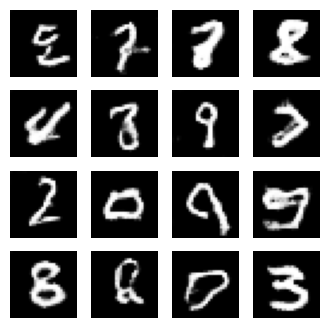

6000 [D 손실: 0.397804, 정확도: 80.86%] [G 손실: 2.048268]


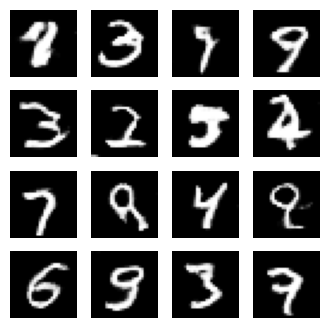

7000 [D 손실: 0.403438, 정확도: 80.47%] [G 손실: 1.666974]


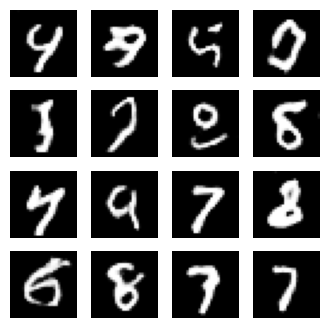

8000 [D 손실: 0.396707, 정확도: 79.30%] [G 손실: 1.977972]


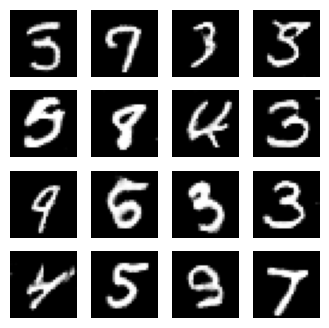

9000 [D 손실: 0.424274, 정확도: 79.69%] [G 손실: 1.706589]


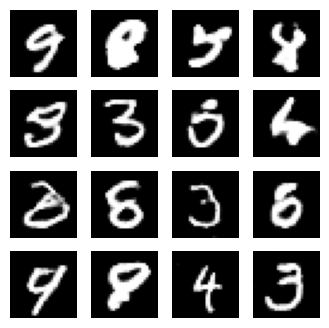

10000 [D 손실: 0.442605, 정확도: 80.08%] [G 손실: 1.984084]


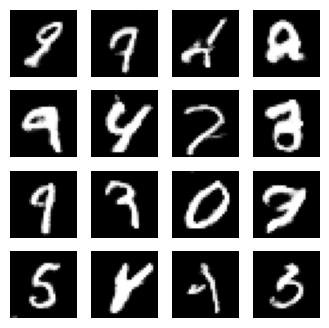

11000 [D 손실: 0.338812, 정확도: 84.77%] [G 손실: 2.251451]


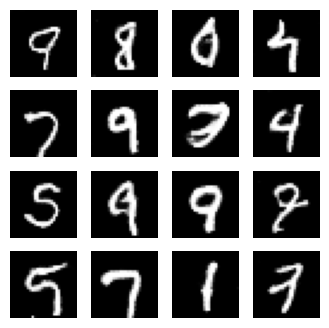

12000 [D 손실: 0.309577, 정확도: 87.50%] [G 손실: 2.196000]


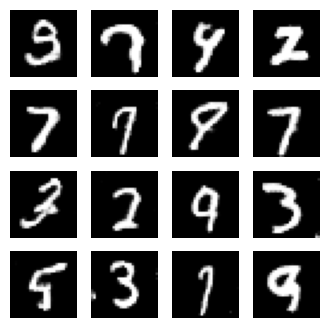

13000 [D 손실: 0.415321, 정확도: 80.86%] [G 손실: 1.835047]


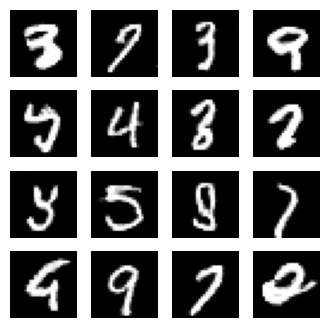

14000 [D 손실: 0.412630, 정확도: 80.86%] [G 손실: 1.952972]


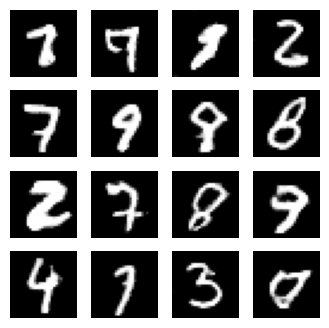

15000 [D 손실: 0.371751, 정확도: 80.08%] [G 손실: 2.209896]


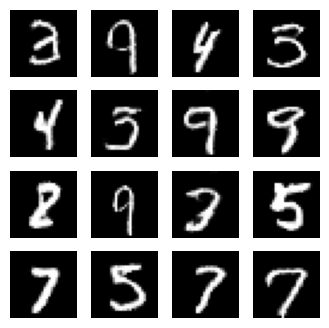

16000 [D 손실: 0.371485, 정확도: 82.03%] [G 손실: 1.640493]


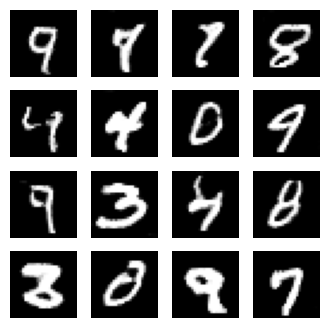

17000 [D 손실: 0.415673, 정확도: 80.08%] [G 손실: 2.091627]


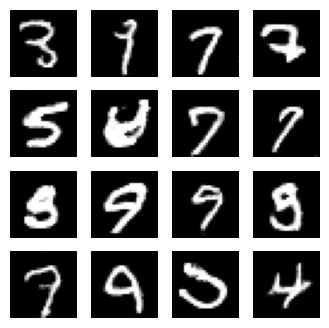

18000 [D 손실: 0.392173, 정확도: 82.42%] [G 손실: 2.008250]


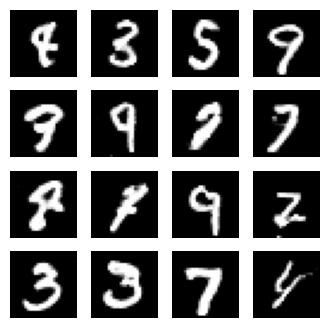

19000 [D 손실: 0.373324, 정확도: 82.42%] [G 손실: 2.183874]


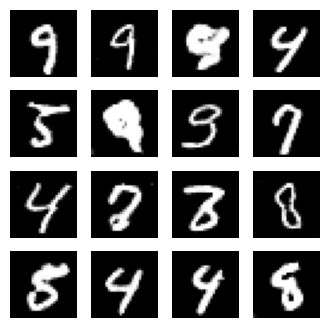

20000 [D 손실: 0.369262, 정확도: 83.20%] [G 손실: 2.291232]


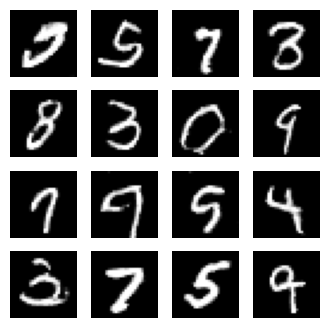

CPU times: user 54min 42s, sys: 2min 36s, total: 57min 18s
Wall time: 1h 6min 46s


In [9]:
%%time
# 하이퍼파라미터 설정
iterations = 20000
batch_size = 128
sample_interval = 1000

# 지정된 반복 횟수만큼 DCGAN 훈련
train(iterations, batch_size, sample_interval)

## 결과 그래프

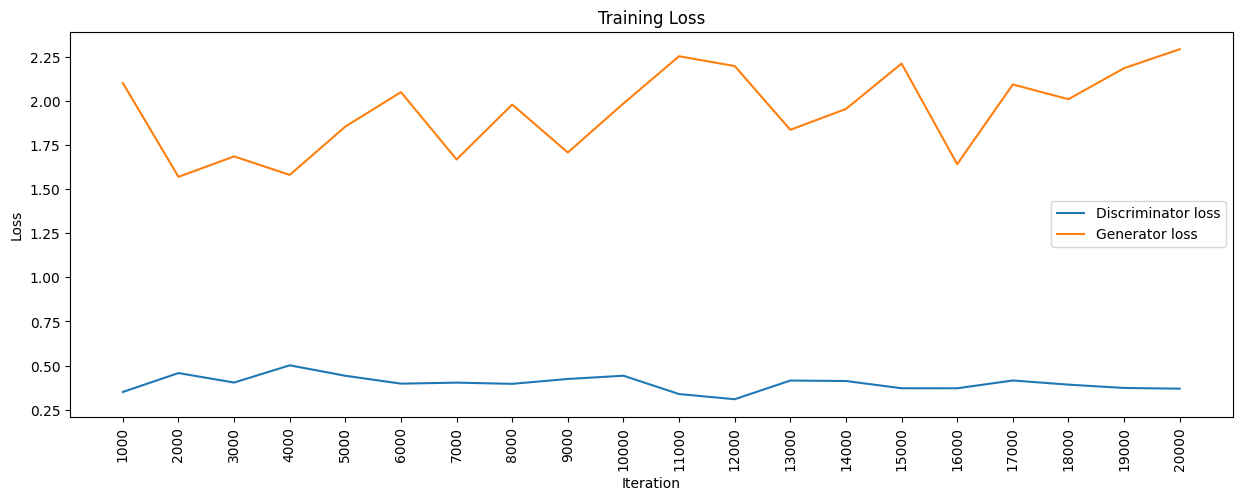

In [10]:
losses = np.array(losses)

# 판별자와 생성자의 훈련 손실 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

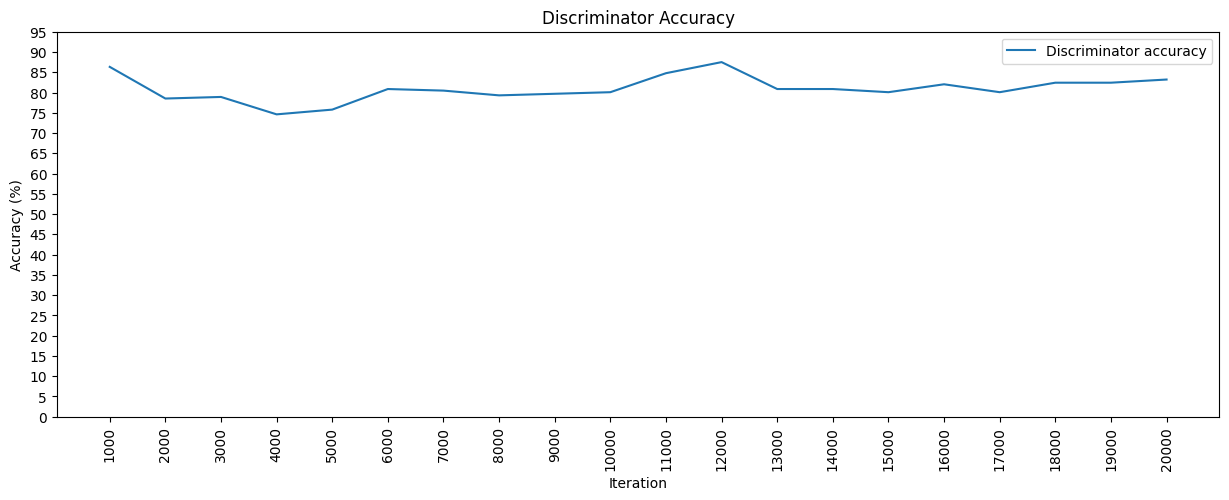

In [11]:
accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()